## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [203]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [204]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [205]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [206]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [207]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [208]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [209]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [210]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [211]:
target = 'survived'

In [212]:
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [213]:
print("number of values in")
for col in data:
    print("{} has {} unique values".format(col, len(data[col].unique())))

number of values in
pclass has 3 unique values
survived has 2 unique values
sex has 2 unique values
age has 99 unique values
sibsp has 7 unique values
parch has 8 unique values
fare has 282 unique values
cabin has 182 unique values
embarked has 4 unique values
title has 5 unique values


In [214]:
data.columns

Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title'],
      dtype='object')

In [215]:

vars_num = ["age", "fare", "pclass", "sibsp", "parch"]

vars_cat = ["sex", "embarked", "title", "cabin"]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [216]:
# first in numerical variables
missing_num = {}
N = len(data)
for var in vars_num:
    missing_num[var] = data[var].isna()
    print("{} has {}% missing".format(var,sum(data[var].isna())/N*100))

age has 20.091673032849503% missing
fare has 0.07639419404125286% missing
pclass has 0.0% missing
sibsp has 0.0% missing
parch has 0.0% missing


In [217]:
# now in categorical variables
missing_cat = {}
for var in vars_cat:
    missing_cat[var] = data[var].isna()
    print("{} has {:.2f}% missing".format(var,sum(data[var].isna())/N*100))

sex has 0.00% missing
embarked has 0.15% missing
title has 0.00% missing
cabin has 77.46% missing


### Determine cardinality of categorical variables

In [218]:
for var in vars_cat:
    print("{} has cardinality {}".format(var, len(data[var].unique())))

sex has cardinality 2
embarked has cardinality 4
title has cardinality 5
cabin has cardinality 182


### Determine the distribution of numerical variables

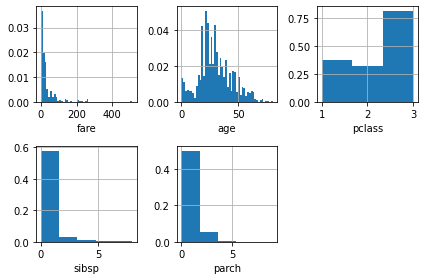

In [223]:
import matplotlib.pyplot as plt
plt.subplot(2,3,1)
data['fare'].hist(bins=50, density=True)
plt.xlabel("fare")

plt.subplot(2, 3, 2)
data["age"].hist(bins=50, density=True)
plt.xlabel("age")

plt.subplot(2, 3, 3)
data["pclass"].hist(bins=3, density=True)
plt.xlabel("pclass")
plt.tight_layout()

plt.subplot(2, 3, 4)
data["sibsp"].hist(bins=5, density=True)
plt.xlabel("sibsp")

plt.subplot(2, 3, 5)
data["parch"].hist(bins=5, density=True)
plt.xlabel("parch")
plt.tight_layout()
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [224]:

data.loc[~missing_cat['cabin'],'cabin'] =  [cabin[0] for cabin in data["cabin"][~missing_cat['cabin']].to_list()]
data["cabin"].unique().tolist()

['B', 'C', 'E', 'D', 'A', nan, 'T', 'F', 'G']

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [239]:
for var in vars_num:
    if sum(data[var].isna()):
        data[var + "_missing"] = missing_num[var]
        data.loc[data[var].isna(), var] = data[var].median()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        1309 non-null   float64
 1   survived      1309 non-null   int64  
 2   sex           1309 non-null   object 
 3   age           1309 non-null   float64
 4   sibsp         1309 non-null   float64
 5   parch         1309 non-null   float64
 6   fare          1309 non-null   float64
 7   cabin         1309 non-null   object 
 8   embarked      1309 non-null   object 
 9   title         1309 non-null   object 
 10  age_missing   1309 non-null   bool   
 11  fare_missing  1309 non-null   bool   
dtypes: bool(2), float64(5), int64(1), object(4)
memory usage: 104.9+ KB


### Replace Missing data in categorical variables with the string **Missing**

In [240]:
for var in vars_cat:
    data.loc[data[var].isna(), var] = "missing"

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        1309 non-null   float64
 1   survived      1309 non-null   int64  
 2   sex           1309 non-null   object 
 3   age           1309 non-null   float64
 4   sibsp         1309 non-null   float64
 5   parch         1309 non-null   float64
 6   fare          1309 non-null   float64
 7   cabin         1309 non-null   object 
 8   embarked      1309 non-null   object 
 9   title         1309 non-null   object 
 10  age_missing   1309 non-null   bool   
 11  fare_missing  1309 non-null   bool   
dtypes: bool(2), float64(5), int64(1), object(4)
memory usage: 104.9+ KB


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [242]:
for var in vars_cat:
    print(var)
    for cat in data[var].unique().tolist():
        print("\t category {} appears {}%".format(cat, sum(data[var]==cat)/N*100))

sex
	 category female appears 35.59969442322384%
	 category male appears 64.40030557677616%
embarked
	 category S appears 69.82429335370512%
	 category C appears 20.626432391138273%
	 category missing appears 0.15278838808250572%
	 category Q appears 9.396485867074103%
title
	 category Miss appears 19.709702062643238%
	 category Master appears 4.660045836516425%
	 category Mr appears 57.90679908326967%
	 category Mrs appears 15.355233002291827%
	 category Other appears 2.3682200152788386%
cabin
	 category B appears 4.965622612681436%
	 category C appears 7.18105423987777%
	 category E appears 3.132161955691368%
	 category D appears 3.514132925897632%
	 category A appears 1.680672268907563%
	 category missing appears 77.46371275783041%
	 category T appears 0.07639419404125286%
	 category F appears 1.6042780748663104%
	 category G appears 0.38197097020626436%


In [247]:

data.loc[(data["title"]=="Other") | (data["title"]=="Master"), "title"] = "rare"
data.loc[(data["cabin"]=="E") | (data["cabin"]=="D") | (data["cabin"]=="A") | (data["cabin"]=="T") | (data["cabin"]=="F") | (data["cabin"]=="G"), "cabin"] = "rare"
data.loc[(data["cabin"]=="E") | (data["cabin"]=="D"), "cabin"] = "rare"

In [248]:
data['cabin'].unique().tolist()

['B', 'C', 'rare', 'missing']

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [249]:

for cat in data["cabin"].unique().tolist():
    if cat != "missing":
        data["cabin_" + cat] = data["cabin"]==cat
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        1309 non-null   float64
 1   survived      1309 non-null   int64  
 2   sex           1309 non-null   object 
 3   age           1309 non-null   float64
 4   sibsp         1309 non-null   float64
 5   parch         1309 non-null   float64
 6   fare          1309 non-null   float64
 7   cabin         1309 non-null   object 
 8   embarked      1309 non-null   object 
 9   title         1309 non-null   object 
 10  age_missing   1309 non-null   bool   
 11  fare_missing  1309 non-null   bool   
 12  cabin_B       1309 non-null   bool   
 13  cabin_C       1309 non-null   bool   
 14  cabin_rare    1309 non-null   bool   
dtypes: bool(5), float64(5), int64(1), object(4)
memory usage: 108.8+ KB


In [250]:
data["female"] = data["sex"]=="female"

In [251]:
for cat in data["embarked"].unique().tolist():
    if cat != "missing":
        data["embarked_" + cat] = data["embarked"]==cat
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        1309 non-null   float64
 1   survived      1309 non-null   int64  
 2   sex           1309 non-null   object 
 3   age           1309 non-null   float64
 4   sibsp         1309 non-null   float64
 5   parch         1309 non-null   float64
 6   fare          1309 non-null   float64
 7   cabin         1309 non-null   object 
 8   embarked      1309 non-null   object 
 9   title         1309 non-null   object 
 10  age_missing   1309 non-null   bool   
 11  fare_missing  1309 non-null   bool   
 12  cabin_B       1309 non-null   bool   
 13  cabin_C       1309 non-null   bool   
 14  cabin_rare    1309 non-null   bool   
 15  female        1309 non-null   bool   
 16  embarked_S    1309 non-null   bool   
 17  embarked_C    1309 non-null   bool   
 18  embarked_Q    1309 non-null 

In [ ]:
for cat in data["title"].unique().tolist():
    if cat != "rare":
        data["title_" + cat] = data["title"]==cat
data.info()

In [255]:
data_use = data.drop(columns=["sex", "cabin", "embarked", "title"])

X_train, X_test, y_train, y_test = train_test_split(
    data_use.drop('survived', axis=1),  # predictors
    data_use['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 17), (262, 17))

### Scale the variables

- Use the standard scaler from Scikit-learn

In [261]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [263]:
from sklearn.linear_model import Lasso

lin_model = Lasso(alpha=0.0005, random_state=0)
# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [277]:
from sklearn.metrics import accuracy_score
y_test_prob = lin_model.predict(X_test)
y_train_prob = lin_model.predict(X_train)

y_test_pred = y_test_prob > 0.5
y_train_pred = y_train_prob > 0.5
#
#
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

auc = roc_auc_score(y_test, y_test_prob)

print("Train accuracy was {}".format(train_accuracy))
print("Test accuracy was {}".format(test_accuracy))
print("auc was {}".format(auc))

Train accuracy was 0.8080229226361032
Test accuracy was 0.7977099236641222
auc was 0.8557716049382715


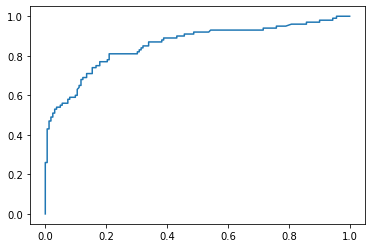

In [276]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)

plt.plot(fpr, tpr)
plt.show()

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**